In [57]:
import re
import os
import numpy as np
from numpy import ndarray
from typing import Any, List, Tuple
from pathlib import Path
import matplotlib.pyplot as plt
import os
import glob
import json

from keras.models import Model
from keras.models import load_model as kload_model

import src.config as config
from osgeo import gdal
from src.gdal_wrapper import gdal_open

In [58]:
notebook_data_path = 'notebook_data/'

vv_name = 'S1A_IW_RT30_20200531T224609_G_gpn_VV.tif'
vh_name = 'S1A_IW_RT30_20200531T224609_G_gpn_VH.tif'

vv_path = notebook_data_path + vv_name
vh_path = notebook_data_path + vh_name

# Function Definitions

### pad_image

In [59]:
# Pads image to proper dems
def pad_image(image: np.ndarray, to: int) -> np.ndarray:
    height, width = image.shape

    n_rows, n_cols = get_tile_row_col_count(height, width, to)
    new_height = n_rows * to
    new_width = n_cols * to

    padded = np.zeros((new_height, new_width))
    padded[:image.shape[0], :image.shape[1]] = image
    return padded

### tile_image

In [60]:
def tile_image(image: np.ndarray, width: int = 512, height: int = 512) -> np.ndarray:
    _nrows, _ncols = image.shape
    _strides = image.strides

    nrows, _m = divmod(_nrows, height)
    ncols, _n = divmod(_ncols, width)

    assert _m == 0, "Image must be evenly tileable. Please pad it first"
    assert _n == 0, "Image must be evenly tileable. Please pad it first"

    return np.lib.stride_tricks.as_strided(
        np.ravel(image),
        shape=(nrows, ncols, height, width),
        strides=(height * _strides[0], width * _strides[1], *_strides),
        writeable=False
    ).reshape(nrows * ncols, height, width)

### get_tile_row_col_count

In [61]:
def get_tile_row_col_count(height: int, width: int, tile_size: int) -> Tuple[int, int]:
    return int(np.ceil(height / tile_size)), int(np.ceil(width / tile_size))

### load_model

In [62]:
def load_model(model_path: str) -> Model:
    """ Loads and returns a model. Attaches the model name and that model's
    history. """
    model_dir = os.path.dirname(model_path)
    print(f"model_dir: {model_dir}")
    model = kload_model(model_path)

    # Attach our extra data to the model
    model.__asf_model_name = model_path

    return model

### write_mask_to_file

In [63]:
def write_mask_to_file(mask: np.ndarray, file_name: str, projection: str, geo_transform: str) -> None:
    (width, height) = mask.shape
    out_image = gdal.GetDriverByName('GTiff').Create(
        file_name, height, width, bands=1
    )
    out_image.SetProjection(projection)
    out_image.SetGeoTransform(geo_transform)
    out_image.GetRasterBand(1).WriteArray(mask)
    out_image.GetRasterBand(1).SetNoDataValue(0)
    out_image.FlushCache()

### plot_image & show_image

<font face="Calibri" size="3"> Matplotlib's plotting functions allow for powerful options to display imagery. We are following some standard approaches for setting up figures.
First we are looking at a **raster band** and it's associated **histogram**. </font>
<br><br>
<font face="Calibri" size="3"> Our function, *show_image()* takes several parameters:
    
- raster = a numpy two dimensional array 
- tindex = a panda index array for dates
- bandnbr = the band number the corresponds to the raster 
- vmin = minimim value to display 
- vmax = maximum value to display
- output_filename = name of output file, if saving the plot
<br><br>
It then calls a function called plot_image_histogram that does the actual plotting.
</font>

In [64]:
def plot_image(axs, raster, vmin=None, vmax=None):
    # plot image
    vmin = np.percentile(raster, 1) if vmin==None else vmin
    vmax = np.percentile(raster, 99) if vmax==None else vmax
    axs[0].imshow(raster, cmap='gray', vmin=vmin, vmax=vmax)
    axs[0].set_title('Image')

def show_image(raster, vmin=None, vmax=None, output_filename=None):  
    fig, axs = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches((14,7), forward=True)
    plt.subplots_adjust(wspace=0.3)
    plt.rcParams.update({'font.size': 14})
    plot_image(axs, raster, vmin=vmin, vmax=vmax)
    if output_filename:
        plt.savefig(output_filename, dpi=300, transparent='true')

# Visualize VV & VH

Viewing raster S1A_IW_RT30_20200531T224609_G_gpn_VV.tif


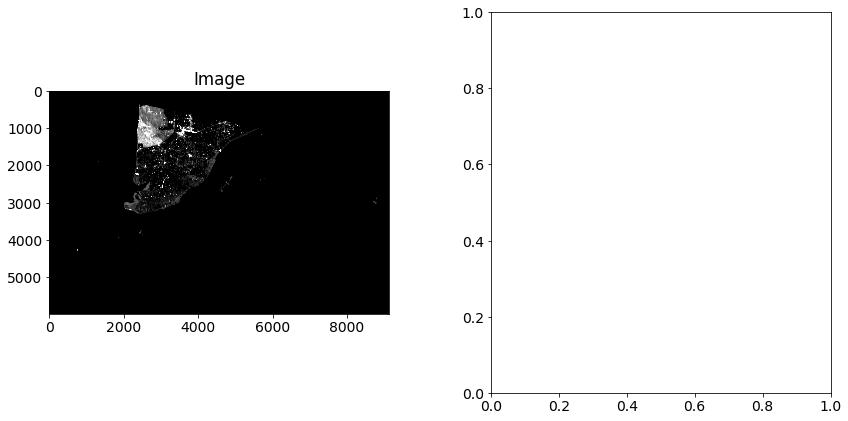

In [65]:
ds_vv = gdal.Open(vv_path)

raster_vv = ds_vv.GetRasterBand(1).ReadAsArray()

print(f'Viewing raster {vv_name}')
show_image(raster_vv, vmin=0.1, vmax=0.4)

Viewing raster S1A_IW_RT30_20200531T224609_G_gpn_VH.tif


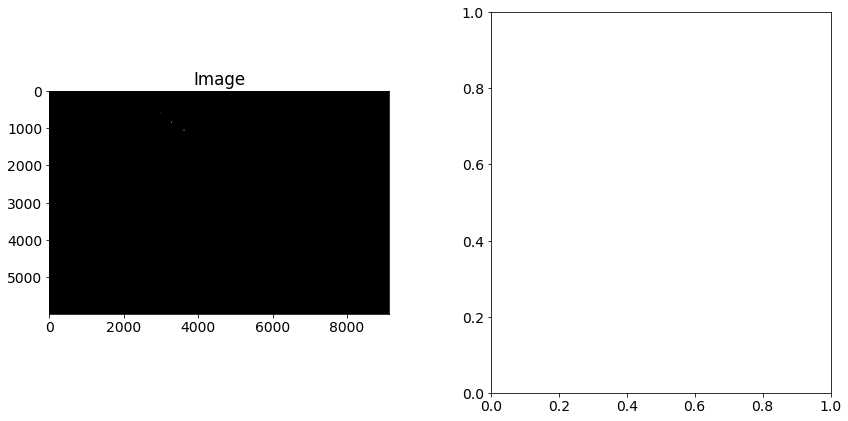

In [66]:
ds_vh = gdal.Open(vh_path)

raster_vh = ds_vh.GetRasterBand(1).ReadAsArray()

print(f'Viewing raster {vh_name}')
show_image(raster_vh, vmin=0.1, vmax=0.4)

# Run Flood Mapping

### Load the AI_Water model and print a summary of its fully convolutional neural network architecture

In [67]:
current_model_path = '/home/jmherning/code/asf/AI_Water/models/AI_FCN_512'

model_path = f'{current_model_path}/latest.h5'
model = load_model(model_path)
print(model.summary())

model_dir: /home/jmherning/code/asf/AI_Water/models/AI_FCN_512
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 2) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 16) 304         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 512, 512, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 512, 512, 16) 0           batch_normalization_2[0][0]      
_____________________________

In [68]:
def get_tiff_paths(paths: str) -> list:
    tiff_paths = !ls $paths | sort -t_ -k5,5
    return tiff_paths

In [69]:
while True:
    print("Enter the absolute path to the directory holding your tiffs.")
    tiff_dir = input()
    paths = f"{tiff_dir}/*.tif*"
    if os.path.exists(tiff_dir):
        tiff_paths = get_tiff_paths(paths)
        if len(tiff_paths) < 1:
            print(f"{tiff_dir} exists but contains no tifs.")
            print("You will not be able to proceed until tifs are prepared.")
        break
    else:
        print(f"\n{tiff_dir} does not exist.")
        continue

Enter the absolute path to the directory holding your tiffs.
/home/jmherning/code/asf/AI_Water/notebook_data


In [70]:
def group_polarizations(tiff_paths: list) -> dict:
    pths = {}
    for tiff in tiff_paths:
        product_name = tiff.split('.')[0][:-2]
        if product_name in pths:
            pths[product_name].append(tiff)
        else:
            pths.update({product_name: [tiff]})
            pths[product_name].sort()
    return pths

In [71]:
def confirm_dual_polarizations(paths: dict) -> bool:
    for p in paths:
        if len(paths[p]) == 2:
            if ('vv' not in paths[p][1] and 'VV' not in paths[p][1]) or \
            ('vh' not in paths[p][0] and 'VH' not in paths[p][0]):
                return False
    return True   

In [72]:
grouped_pths = group_polarizations(tiff_paths)
if not confirm_dual_polarizations(grouped_pths):
    print("ERROR: AI_Water requires both VV and VH polarizations.")
else:
    print("Confirmed presence of VV and VH polarities for each product.")
    
print(grouped_pths) #uncomment to print VV/VH path pairs

Confirmed presence of VV and VH polarities for each product.
{'/home/jmherning/code/asf/AI_Water/notebook_data/S1A_IW_RT30_20200531T224609_G_gpn_': ['/home/jmherning/code/asf/AI_Water/notebook_data/S1A_IW_RT30_20200531T224609_G_gpn_VH.tif', '/home/jmherning/code/asf/AI_Water/notebook_data/S1A_IW_RT30_20200531T224609_G_gpn_VV.tif']}


In [73]:

mask_directory = notebook_data_path

for pair in grouped_pths:
    for tiff in grouped_pths[pair]:
        f = gdal.Open(tiff)
        img_array = f.ReadAsArray()
        original_shape = img_array.shape
        n_rows, n_cols = get_tile_row_col_count(*original_shape, tile_size=512)
        print(f'tiff: {tiff}')
        if 'vv' in tiff or 'VV' in tiff:
            vv_array = pad_image(f.ReadAsArray(), 512)
            invalid_pixels = np.nonzero(vv_array == 0.0)
            vv_tiles = tile_image(vv_array)
        else:
            vh_array = pad_image(f.ReadAsArray(), 512)
            invalid_pixels = np.nonzero(vh_array == 0.0)
            vh_tiles = tile_image(vh_array)
            
    # Predict masks
    masks = model.predict(
        np.stack((vh_tiles, vv_tiles), axis=3), batch_size=1, verbose=1
    )
    masks.round(decimals=0, out=masks)
    # Stitch masks together
    mask = masks.reshape((n_rows, n_cols, 512, 512)) \
                .swapaxes(1, 2) \
                .reshape(n_rows * 512, n_cols * 512)  # yapf: disable

    mask[invalid_pixels] = 0
    filename, ext = os.path.basename(tiff).split('.')
    outfile = f"{mask_directory}/{filename[:-3]}_water_mask.{ext}"
    write_mask_to_file(mask, outfile, f.GetProjection(), f.GetGeoTransform())

tiff: /home/jmherning/code/asf/AI_Water/notebook_data/S1A_IW_RT30_20200531T224609_G_gpn_VH.tif
tiff: /home/jmherning/code/asf/AI_Water/notebook_data/S1A_IW_RT30_20200531T224609_G_gpn_VV.tif
216/216 [==============================] - 19s 89ms/step
